In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import pandas as pd

# HELPERS

In [2]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_dirs = ["../../Palatino/"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
font_manager.get_font_names()

plt.rcParams["font.family"] = "Palatino"


In [3]:
def write_yaml_file(file, data):
    with open(file, "w") as f:
        f.writelines(x + '\n' for x in data)

In [4]:
def load_pkl_dict(filename, folder):
    with open(folder + filename, "rb") as f:
        loaded_file = pickle.load(f)
        df = pd.DataFrame.from_dict(loaded_file, orient='columns')
        return df

In [5]:
def plot_df(dfp, title, labels=None, combine=False):
    fig, axs = plt.subplots(1,1)

    axs.title.set_text(f"{title}")
    axs.set_xlabel('FPR')
    axs.set_ylabel('CCR')
    axs.grid()
    axs.set_xscale('log')
    # axs[row][col].set_xlim([0, 1])  # sets the x-axis limits
    axs.set_ylim([0, 1]) # sets the y-axis limits
    axs.set_xlim(8 * 1e-5, 1.4)
    
    if labels is None:
        for index, row in dfp.iterrows():
            axs.plot(row['FPR'], row['CCR'], label=f"$\\alpha$: {row['ALPHA']},  $\eta$: {row['TAILSIZE']},  $\kappa$: {row['DIST_MULT']}")
    elif labels is not None and combine:
        counter = 0
        for index, row in dfp.iterrows():
            axs.plot(row['FPR'], row['CCR'], label=f"{labels[counter]}: $\\alpha$: {row['ALPHA']},  $\eta$: {row['TAILSIZE']},  $\kappa$: {row['DIST_MULT']}")
            counter += 1
        
    else:
        counter = 0
        for index, row in dfp.iterrows():
            axs.plot(row['FPR'], row['CCR'], label=labels[counter])
            counter += 1
    
        
    axs.legend(loc="upper left") 
    plt.savefig(f"output/{title}.png")
    plt.show()

In [6]:
def plot_df_double(dfp, dfp1, title, label):
    fig, axs = plt.subplots(1,1)

    axs.title.set_text(f"{title}")
    axs.set_xlabel('FPR')
    axs.set_ylabel('CCR')
    axs.grid()
    axs.set_xscale('log')
    # axs[row][col].set_xlim([0, 1])  # sets the x-axis limits
    axs.set_ylim([0, 1]) # sets the y-axis limits
    axs.set_xlim(8 * 1e-4, 1.4)
    
    for index, row in dfp.iterrows():
        axs.plot(row['FPR'], row['CCR'], label=f"{row[f'{label}']}")
        
    for index, row in dfp1.iterrows():
        axs.plot(row['FPR'], row['CCR'], label=f"{row[f'{label}']}")
    
        
    axs.legend(loc="upper left")   
    plt.show()

In [7]:
def oscr_epsilon_ccr_at_fpr(ccr, fpr, fpr_thresholds):
    threshold_values = []
    for threshold in fpr_thresholds:
        idx = np.where(fpr == threshold)
        value = ccr[idx]
        if value.shape[0] == 0:
            value = np.append(value, 0.0)
        threshold_values.append((threshold, value))
    epsilon_score = np.sum([t[1] for t in threshold_values])
    return epsilon_score, threshold_values

In [8]:
def ranking_scores_base(alphas, norms, neg_fix, input_cluster, feature_cluster, types, dataset):
    folder = "../experiment_data/condensed/base/cifar/"
    dfs = []
    for t in types:
        for alpha in alphas:
            for norm in norms:
                for fix in neg_fix:
                    for ic in input_cluster:
                        for fc in feature_cluster:
                            df = load_pkl_dict(f"oscr_data_{t}_{dataset}_{ic}_{fc}_{alpha}_{fix}_{norm}.pkl", folder)
                            df['TYPE'] = t
                            df['ALPHA'] = alpha
                            df['NORM'] = norm
                            df['NEGATIVE_FIX'] = fix
                            df['INPUT-CLUSTER'] = ic
                            df['FEATURES-CLUSTER'] = fc
                            df['GAMMA+'] = df['GAMMA'].apply(lambda x: x[1])
                            df['GAMMA-'] = df['GAMMA'].apply(lambda x: x[2])
                            df['GAMMA_TOTAL'] = df['GAMMA'].apply(lambda x: x[0])
                            df['EPSILON_TOTAL'] = df['EPSILON'].apply(lambda x: x[0])
                            df['CCR'] = df['CCR-FPR'].apply(lambda x: x[0])
                            df['FPR'] = df['CCR-FPR'].apply(lambda x: x[1])
                            
                    dfs.append(df)
    df_final = pd.concat(dfs)
    return df_final

In [9]:
def recalc_epsilon(row, thresholds):
    return oscr_epsilon_ccr_at_fpr(row['CCR'], row['FPR'], thresholds)[0]

In [10]:
def ranking_scores_cluster(alphas, norm, fix, types):
    folder = "../experiment_data/condensed/clusters/cifar/"
    dfs = []
    for t in types:
        for a, n in zip(alphas,norm):
            df = load_pkl_dict(f"oscr_data_{t}.pkl", folder)
            df['TYPE'] = t
            df['ALPHA'] = a
            df['NORM'] = n
            df['NEGATIVE_FIX'] = fix
            df['GAMMA+'] = df['GAMMA'].apply(lambda x: x[1])
            df['GAMMA-'] = df['GAMMA'].apply(lambda x: x[2])
            df['GAMMA_TOTAL'] = df['GAMMA'].apply(lambda x: x[0])
            df['EPSILON_TOTAL'] = df['EPSILON'].apply(lambda x: x[0])
            df['CCR'] = df['CCR-FPR'].apply(lambda x: x[0])
            df['FPR'] = df['CCR-FPR'].apply(lambda x: x[1])
            dfs.append(df)
    df_final = pd.concat(dfs)
    return df_final

In [11]:
alphas = [-1, 3, 5, 7, 10]
norms = ["NONE", "WEIGHTS", "N-CLASSES"]
neg_fixes = ["ORIGINAL", "VALUE_SHIFT", "ADJUSTED_NEGATIVE_VALUE"]
types = ["base", "input-cluster", "validation-features-cluster", "training-features-cluster", "input-training-features-cluster", "input-validation-features-cluster"]
input_cluster = [1]
feature_cluster = [1]
df = ranking_scores_base(alphas, norms, neg_fixes, input_cluster, feature_cluster, types[:1], "CIFAR")

In [12]:
alphas = [7]
norms = ["WEIGHTS", "NONE"]
f = "NONE"
types = ["validation-features-cluster", "training-features-cluster"]
dfc = ranking_scores_cluster(alphas, norms, f, types)

In [13]:
df = pd.concat([df, dfc])
df = df.reset_index()
df = df.rename(columns={'index': 'TAIL-DIST_MULT'})
df[['TAILSIZE', 'DIST_MULT', 'INPUT-CLUSTER', 'FEATURES-CLUSTER']] = df['TAIL-DIST_MULT'].str.extract(r'(\d+)-(-?\d+.\d+)-(\d+)-(\d+)')

In [14]:
df['TAILSIZE'] = df['TAILSIZE'].astype(int)
#df = df.loc[df['TAILSIZE'] <= 1000]

In [15]:
thresholds = [0.1, 0.2, 0.5, 0.7, 1.0]
df['EPSILON_TOTAL'] = df.apply(recalc_epsilon, axis=1, thresholds=thresholds)

# PLOTS

# Experiment 1

In [31]:
table_titles = ["ALPHA", "TAILSIZE", "DIST_MULT", "NORM", "NEGATIVE_FIX","GAMMA+", "GAMMA-", "GAMMA_TOTAL", "EPSILON_TOTAL", "FEATURES-CLUSTER", "INPUT-CLUSTER", "TYPE"]

### BASELINE

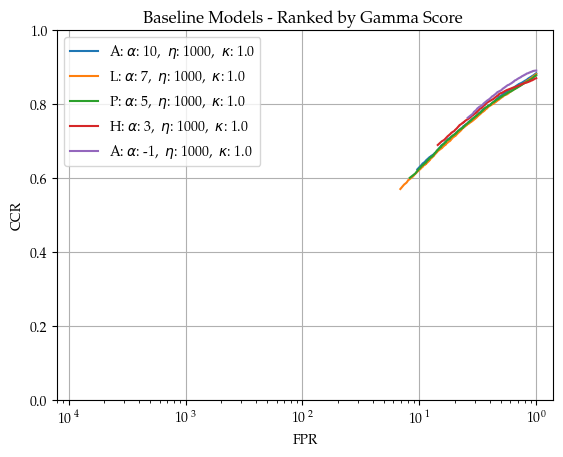

,ALPHA,TAILSIZE,DIST_MULT,NORM,NEGATIVE_FIX,GAMMA+,GAMMA-,GAMMA_TOTAL,EPSILON_TOTAL,FEATURES-CLUSTER,INPUT-CLUSTER
1336,7,1000,1.0,NONE,ORIGINAL,0.724160,0.780957,0.752559,3.8811,1,1
1768,10,1000,1.0,NONE,ORIGINAL,0.751562,0.734982,0.743272,3.2771,1,1
904,5,1000,1.0,NONE,ORIGINAL,0.756631,0.721428,0.739030,3.8883,1,1
472,3,1000,1.0,NONE,ORIGINAL,0.836049,0.459316,0.647683,2.5502,1,1
40,-1,1000,1.0,NONE,ORIGINAL,0.878706,0.226534,0.552620,2.5978,1,1


In [17]:
query = "NEGATIVE_FIX == 'ORIGINAL' and NORM  == 'NONE' and TYPE == 'base'"

df_exp1_base = df.query(query)

exp1_gamma = df_exp1_base.nlargest(1000, 'GAMMA_TOTAL').drop_duplicates(subset=['ALPHA'], keep="first")

plot_df(exp1_gamma.sort_values("ALPHA", ascending=False), "Baseline Models - Ranked by Gamma Score ", "ALPHA", "Alpha")
exp1_gamma[table_titles].to_latex('mytable-gamma.tex')
exp1_gamma[table_titles]

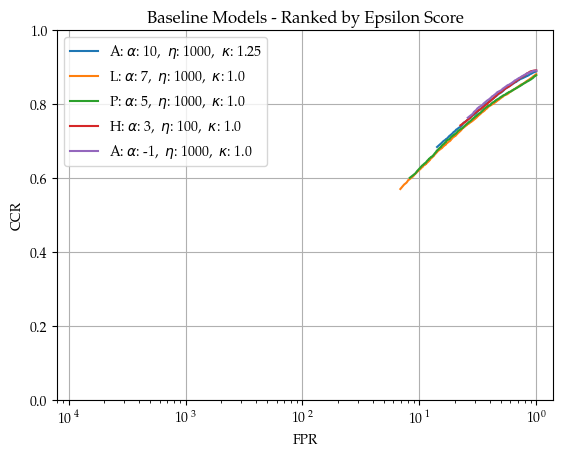

,ALPHA,TAILSIZE,DIST_MULT,NORM,NEGATIVE_FIX,GAMMA+,GAMMA-,GAMMA_TOTAL,EPSILON_TOTAL,FEATURES-CLUSTER,INPUT-CLUSTER
904,5,1000,1.0,NONE,ORIGINAL,0.756631,0.721428,0.739030,3.8883,1,1
1336,7,1000,1.0,NONE,ORIGINAL,0.724160,0.780957,0.752559,3.8811,1,1
1769,10,1000,1.25,NONE,ORIGINAL,0.826834,0.528732,0.677783,3.3109,1,1
40,-1,1000,1.0,NONE,ORIGINAL,0.878706,0.226534,0.552620,2.5978,1,1
440,3,100,1.0,NONE,ORIGINAL,0.888445,0.144615,0.516530,2.5906,1,1


In [18]:
exp1_eps = df_exp1_base.nlargest(1000, 'EPSILON_TOTAL').drop_duplicates(subset=['ALPHA'], keep="first")
plot_df(exp1_eps.sort_values("ALPHA", ascending=False), "Baseline Models - Ranked by Epsilon Score", "ALPHA", "Alpha")
exp1_eps[table_titles].to_latex('mytable-eps.tex')
exp1_eps[table_titles]

# Top Scoring Baseline

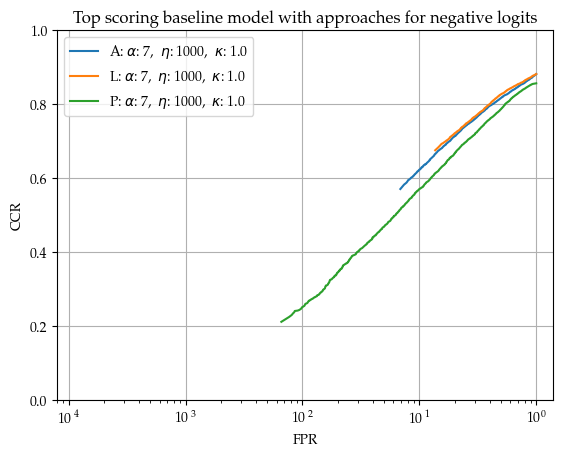

,ALPHA,TAILSIZE,DIST_MULT,NORM,NEGATIVE_FIX,GAMMA+,GAMMA-,GAMMA_TOTAL,EPSILON_TOTAL,FEATURES-CLUSTER,INPUT-CLUSTER
1336,7,1000,1.0,NONE,ORIGINAL,0.724160,0.780957,0.752559,3.8811,1,1
1432,7,1000,1.0,NONE,ADJUSTED_NEGATIVE_VALUE,0.785075,0.649984,0.717530,2.5625,1,1
1384,7,1000,1.0,NONE,VALUE_SHIFT,0.416272,0.965889,0.691080,3.7090,1,1


In [19]:
query = "TYPE == 'base' and ALPHA == 7 and TAILSIZE == 1000 and DIST_MULT == '1.0' and NORM == 'NONE'"

exp1_7 = df.query(query)
exp1_gamma_nf_7 = exp1_7.nlargest(100, 'GAMMA_TOTAL').drop_duplicates(subset=['NEGATIVE_FIX', 'NORM'], keep="first")

labels = ['Original', 'Adjusted Prob.', 'Value Shift']

plot_df(exp1_gamma_nf_7, "Top scoring baseline model with approaches for negative logits", "ALPHA", labels)
exp1_gamma_nf_7
exp1_gamma_nf_7[table_titles]

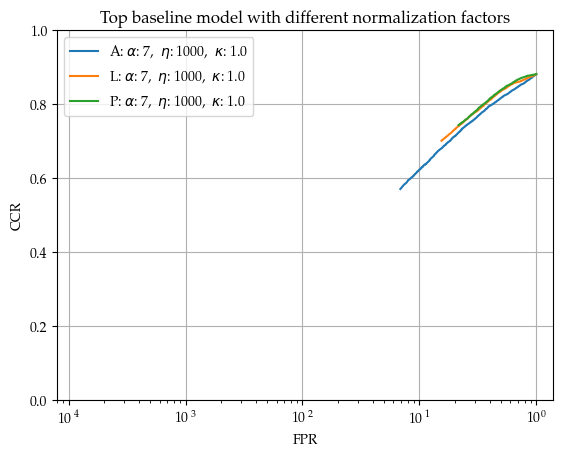

,ALPHA,TAILSIZE,DIST_MULT,NORM,NEGATIVE_FIX,GAMMA+,GAMMA-,GAMMA_TOTAL,EPSILON_TOTAL,FEATURES-CLUSTER,INPUT-CLUSTER
1336,7,1000,1.0,NONE,ORIGINAL,0.724160,0.780957,0.752559,3.8811,1,1
1480,7,1000,1.0,WEIGHTS,ORIGINAL,0.837546,0.486365,0.661956,2.5775,1,1
1624,7,1000,1.0,N-CLASSES,ORIGINAL,0.877654,0.187784,0.532719,2.5867,1,1


In [20]:
query = "TYPE == 'base' and ALPHA == 7 and TAILSIZE == 1000 and DIST_MULT == '1.0' and NEGATIVE_FIX == 'ORIGINAL'"

exp1_7 = df.query(query)
exp1_gamma_nf_7 = exp1_7.nlargest(100, 'GAMMA_TOTAL').drop_duplicates(subset=['NEGATIVE_FIX', 'NORM'], keep="first")

labels = ['$\phi_o$', '$\phi_\omega$', '$\phi_c$']

plot_df(exp1_gamma_nf_7, "Top baseline model with different normalization factors", "ALPHA", labels)
exp1_gamma_nf_7
exp1_gamma_nf_7[table_titles]

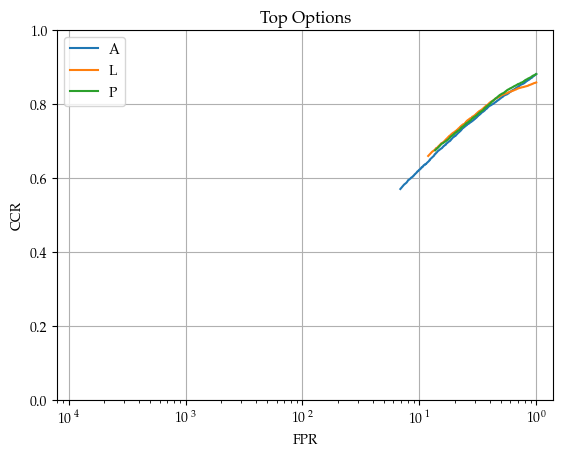

,ALPHA,TAILSIZE,DIST_MULT,NORM,NEGATIVE_FIX,GAMMA+,GAMMA-,GAMMA_TOTAL,EPSILON_TOTAL,FEATURES-CLUSTER,INPUT-CLUSTER
1336,7,1000,1.0,NONE,ORIGINAL,0.724160,0.780957,0.752559,3.8811,1,1
1528,7,1000,1.0,WEIGHTS,VALUE_SHIFT,0.783678,0.664404,0.724041,3.2496,1,1
1432,7,1000,1.0,NONE,ADJUSTED_NEGATIVE_VALUE,0.785075,0.649984,0.717530,2.5625,1,1


In [21]:
query = "TYPE == 'base' and ALPHA == 7 and TAILSIZE == 1000 and DIST_MULT == '1.0'"

exp1_7 = df.query(query)
exp1_gamma_nf_7 = exp1_7.nlargest(3, 'GAMMA_TOTAL').drop_duplicates(subset=['NEGATIVE_FIX', 'NORM'], keep="first")

labels = ['Original + $\phi_o$', 'Adjusted Prob. + $\phi_o$', 'Value Shift + $\phi_\omega$', 'Original + $\phi_\omega$']

plot_df(exp1_gamma_nf_7, "Top Options", "ALPHA")
exp1_gamma_nf_7
exp1_gamma_nf_7[table_titles]

### NEGATIVE_FIX

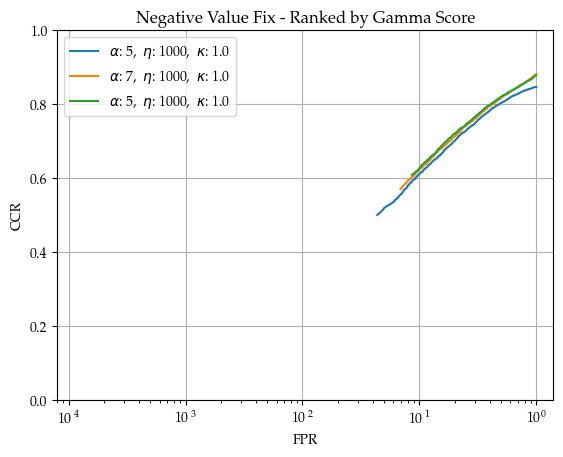

,ALPHA,TAILSIZE,DIST_MULT,NORM,NEGATIVE_FIX,GAMMA+,GAMMA-,GAMMA_TOTAL,EPSILON_TOTAL,FEATURES-CLUSTER,INPUT-CLUSTER
952,5,1000,1.0,NONE,VALUE_SHIFT,0.660869,0.851553,0.756211,3.7901,1,1
1336,7,1000,1.0,NONE,ORIGINAL,0.724160,0.780957,0.752559,3.8811,1,1
1000,5,1000,1.0,NONE,ADJUSTED_NEGATIVE_VALUE,0.759521,0.716268,0.737895,3.2645,1,1


In [22]:
query = "NORM  == 'NONE' and TYPE == 'base'"

exp1_nf = df.query(query)
exp1_gamma_nf = exp1_nf.nlargest(100, 'GAMMA_TOTAL').drop_duplicates(subset=['NEGATIVE_FIX'], keep="first")


plot_df(exp1_gamma_nf, "Negative Value Fix - Ranked by Gamma Score")
exp1_gamma_nf 
exp1_gamma_nf[table_titles]

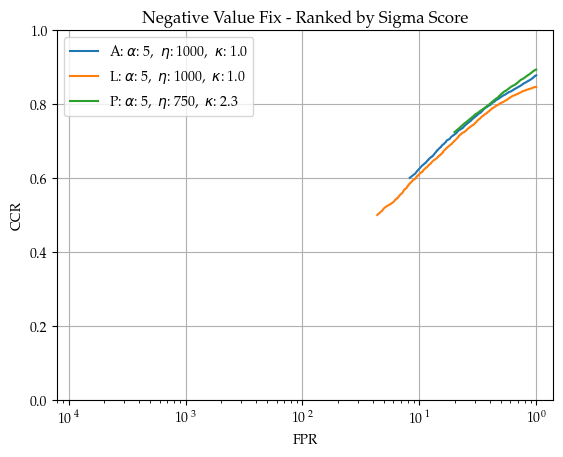

,ALPHA,TAILSIZE,DIST_MULT,NORM,NEGATIVE_FIX,GAMMA+,GAMMA-,GAMMA_TOTAL,EPSILON_TOTAL,FEATURES-CLUSTER,INPUT-CLUSTER
904,5,1000,1.0,NONE,ORIGINAL,0.756631,0.721428,0.739030,3.8883,1,1
952,5,1000,1.0,NONE,VALUE_SHIFT,0.660869,0.851553,0.756211,3.7901,1,1
997,5,750,2.3,NONE,ADJUSTED_NEGATIVE_VALUE,0.892554,0.071612,0.482083,3.3039,1,1


In [23]:
exp1_eps_nf = exp1_nf.nlargest(100, 'EPSILON_TOTAL').drop_duplicates(subset=['NEGATIVE_FIX'], keep="first")


plot_df(exp1_eps_nf, "Negative Value Fix - Ranked by Sigma Score", "ALPHA", combine =  True)
exp1_eps_nf 
exp1_eps_nf[table_titles]

### NORM

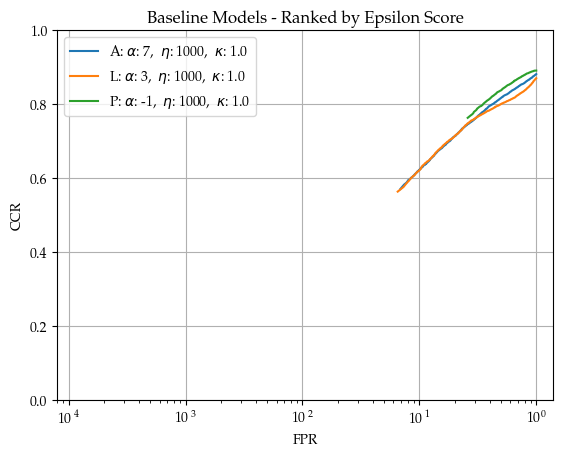

,ALPHA,TAILSIZE,DIST_MULT,NORM,NEGATIVE_FIX,GAMMA+,GAMMA-,GAMMA_TOTAL,EPSILON_TOTAL,FEATURES-CLUSTER,INPUT-CLUSTER
1336,7,1000,1.0,NONE,ORIGINAL,0.724160,0.780957,0.752559,3.8811,1,1
616,3,1000,1.0,WEIGHTS,ORIGINAL,0.757507,0.699072,0.728290,3.8302,1,1
328,-1,1000,1.0,N-CLASSES,ORIGINAL,0.878437,0.228852,0.553644,2.5978,1,1


In [24]:
query = "NEGATIVE_FIX  == 'ORIGINAL' and TYPE == 'base'"

exp1_gamma_norm = df.query(query)
exp1_gamma_norm = exp1_gamma_norm.nlargest(1000, 'GAMMA_TOTAL').drop_duplicates(subset=['NORM'], keep="first")


plot_df(exp1_gamma_norm.sort_values("ALPHA", ascending=False), "Baseline Models - Ranked by Epsilon Score", "ALPHA", "Alpha")
exp1_gamma_norm
exp1_gamma_norm[table_titles]

### All combined

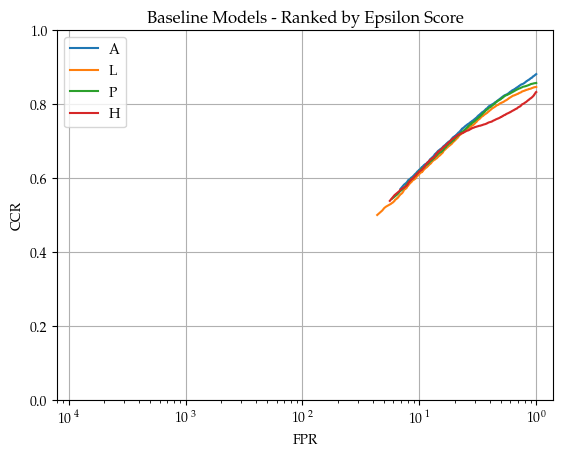

,ALPHA,TAILSIZE,DIST_MULT,NORM,NEGATIVE_FIX,GAMMA+,GAMMA-,GAMMA_TOTAL,EPSILON_TOTAL,FEATURES-CLUSTER,INPUT-CLUSTER
952,5,1000,1.0,NONE,VALUE_SHIFT,0.660869,0.851553,0.756211,3.7901,1,1
944,5,750,1.0,NONE,VALUE_SHIFT,0.703800,0.803094,0.753447,3.2201,1,1
1336,7,1000,1.0,NONE,ORIGINAL,0.724160,0.780957,0.752559,3.8811,1,1
664,3,1000,1.0,WEIGHTS,VALUE_SHIFT,0.713151,0.781288,0.747220,3.7175,1,1


In [25]:
query = "TYPE == 'base'"

exp1_combined = df.query(query)
exp1_gamma_combined = exp1_combined.nlargest(4, 'GAMMA_TOTAL')#.drop_duplicates(subset=['NORM', 'NEGATIVE_FIX', 'NORM'], keep="first")


plot_df(exp1_gamma_combined.sort_values("ALPHA", ascending=False), "Baseline Models - Ranked by Epsilon Score", "ALPHA")
exp1_gamma_combined
exp1_gamma_combined[table_titles]

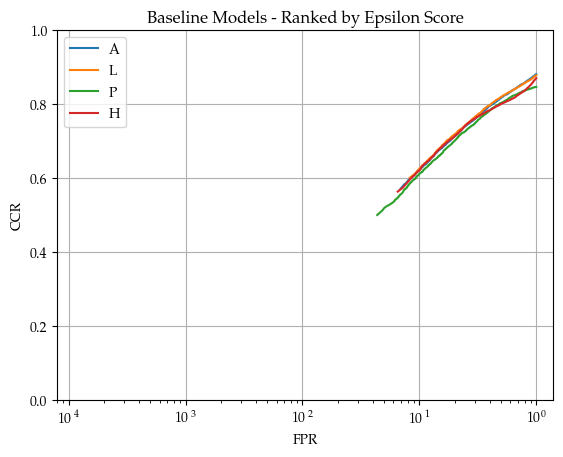

,ALPHA,TAILSIZE,DIST_MULT,NORM,NEGATIVE_FIX,GAMMA+,GAMMA-,GAMMA_TOTAL,EPSILON_TOTAL,FEATURES-CLUSTER,INPUT-CLUSTER
904,5,1000,1.0,NONE,ORIGINAL,0.756631,0.721428,0.739030,3.8883,1,1
1336,7,1000,1.0,NONE,ORIGINAL,0.724160,0.780957,0.752559,3.8811,1,1
616,3,1000,1.0,WEIGHTS,ORIGINAL,0.757507,0.699072,0.728290,3.8302,1,1
952,5,1000,1.0,NONE,VALUE_SHIFT,0.660869,0.851553,0.756211,3.7901,1,1


In [26]:
exp1_eps_combined = exp1_combined.nlargest(5, 'EPSILON_TOTAL').drop_duplicates(subset=["GAMMA_TOTAL"], keep="first")


plot_df(exp1_eps_combined.sort_values("ALPHA", ascending=False), "Baseline Models - Ranked by Epsilon Score", "ALPHA")
exp1_eps_combined
exp1_eps_combined[table_titles]

### CLUSTER VS NON-CLUSTER

In [27]:
exp1_gamma_top = exp1_gamma_combined.nlargest(1, 'GAMMA_TOTAL').drop_duplicates(subset=['ALPHA', 'NORM', 'NEGATIVE_FIX'], keep="first")
exp1_eps_top = df.nlargest(1, 'EPSILON_TOTAL').drop_duplicates(subset=['ALPHA', 'NORM', 'NEGATIVE_FIX'], keep="first")

# Exp 2 + 3

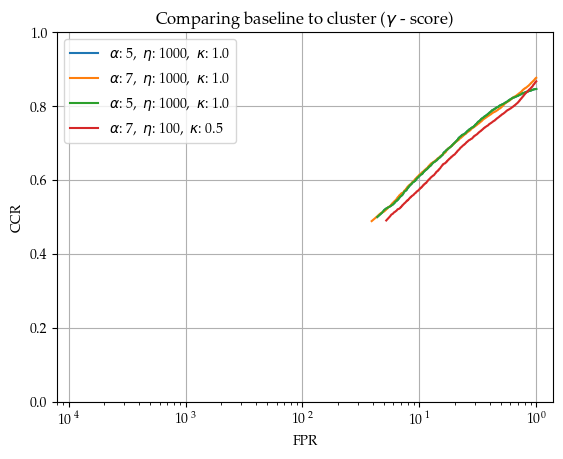

,ALPHA,TAILSIZE,DIST_MULT,NORM,NEGATIVE_FIX,GAMMA+,GAMMA-,GAMMA_TOTAL,EPSILON_TOTAL,FEATURES-CLUSTER,INPUT-CLUSTER,TYPE
952,5,1000,1.0,NONE,VALUE_SHIFT,0.660869,0.851553,0.756211,3.7901,1,1,base
3056,7,1000,1.0,WEIGHTS,NONE,0.657353,0.856664,0.757009,3.8205,3,1,training-features-cluster
952,5,1000,1.0,NONE,VALUE_SHIFT,0.660869,0.851553,0.756211,3.7901,1,1,base
2613,7,100,0.5,WEIGHTS,NONE,0.631707,0.849850,0.740778,3.6965,2,1,validation-features-cluster


In [33]:
#query = "TYPE == 'training-features-cluster' and ALPHA == 7"

df_exp2 = df.copy()

exp2_gamma_top = df_exp2.nlargest(80000, 'GAMMA_TOTAL').drop_duplicates(subset=['TYPE'], keep="first")

df_t_gamma = pd.concat([exp1_gamma_top, exp2_gamma_top])

plot_df(df_t_gamma, "Comparing baseline to cluster ($\gamma$ - score) ")
#exp2_gamma[table_titles].to_latex('mytable-gamma.tex')
df_t_gamma[table_titles]

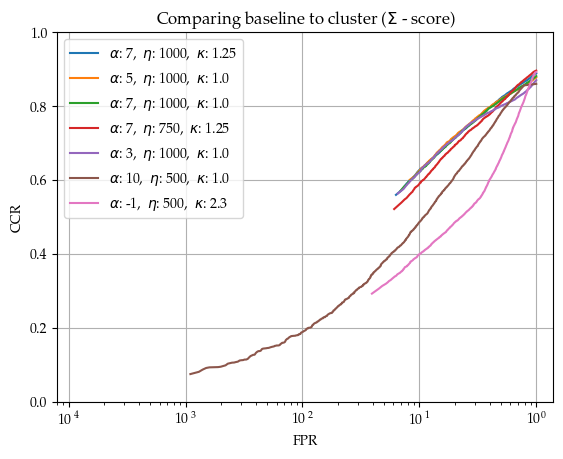

,ALPHA,TAILSIZE,DIST_MULT,NORM,NEGATIVE_FIX,GAMMA+,GAMMA-,GAMMA_TOTAL,EPSILON_TOTAL,FEATURES-CLUSTER,INPUT-CLUSTER,TYPE
2775,7,1000,1.25,WEIGHTS,NONE,0.748973,0.730189,0.739581,3.9066,3,1,training-features-cluster
904,5,1000,1.0,NONE,ORIGINAL,0.756631,0.721428,0.739030,3.8883,1,1,base
1336,7,1000,1.0,NONE,ORIGINAL,0.724160,0.780957,0.752559,3.8811,1,1,base
2370,7,750,1.25,WEIGHTS,NONE,0.774158,0.618812,0.696485,3.8470,2,1,validation-features-cluster
616,3,1000,1.0,WEIGHTS,ORIGINAL,0.757507,0.699072,0.728290,3.8302,1,1,base
1800,10,500,1.0,NONE,VALUE_SHIFT,0.198133,0.988914,0.593523,3.5767,1,1,base
77,-1,500,2.3,NONE,VALUE_SHIFT,0.551521,0.678495,0.615008,3.2109,1,1,base


In [42]:
exp2_eps_top = df_exp2.nlargest(109393939, 'EPSILON_TOTAL').drop_duplicates(subset=['ALPHA', 'TYPE'], keep="first")
#.drop_duplicates(subset=['ALPHA'], keep="first")

df_t_eps = pd.concat([exp2_eps_top])

plot_df(df_t_eps, "Comparing baseline to cluster ($\Sigma$ - score)")
#exp2_gamma[table_titles].to_latex('mytable-gamma.tex')
df_t_eps[table_titles]

### Impact of Cluster Sizes

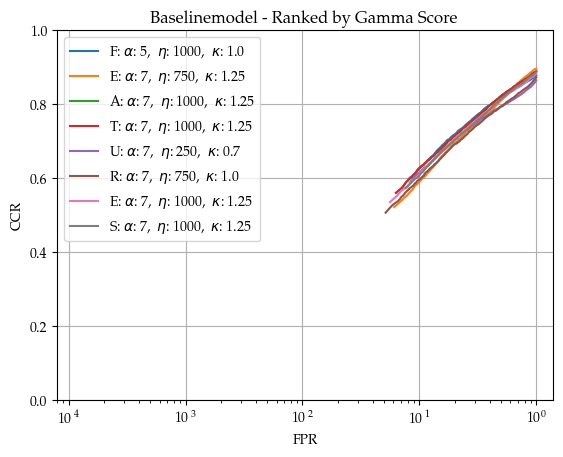

,ALPHA,TAILSIZE,DIST_MULT,NORM,NEGATIVE_FIX,GAMMA+,GAMMA-,GAMMA_TOTAL,EPSILON_TOTAL,FEATURES-CLUSTER,INPUT-CLUSTER
2775,7,1000,1.25,WEIGHTS,NONE,0.748973,0.730189,0.739581,3.9066,3,1
2775,7,1000,1.25,WEIGHTS,NONE,0.748973,0.730189,0.739581,3.9066,3,1
904,5,1000,1.0,NONE,ORIGINAL,0.756631,0.721428,0.739030,3.8883,1,1
3024,7,1000,1.25,WEIGHTS,NONE,0.757285,0.684845,0.721065,3.8609,7,1
2949,7,1000,1.25,WEIGHTS,NONE,0.758232,0.687121,0.722677,3.8599,6,1
2370,7,750,1.25,WEIGHTS,NONE,0.774158,0.618812,0.696485,3.8470,2,1
2689,7,250,0.7,WEIGHTS,NONE,0.700288,0.802853,0.751571,3.7983,4,1
2738,7,750,1.0,WEIGHTS,NONE,0.701489,0.777385,0.739437,3.7826,5,1


In [30]:
query = "TYPE == 'training-features-cluster"
exp2_eps_clust = df_exp2.nlargest(1000, 'EPSILON_TOTAL').drop_duplicates(subset=['FEATURES-CLUSTER'], keep="first")
exp2_eps_clust = pd.concat([exp1_eps_top, exp2_eps_clust])
plot_df(exp2_eps_clust.sort_values("FEATURES-CLUSTER", ascending=True ), "Baselinemodel - Ranked by Gamma Score ", "FEATURES-CLUSTER", "Nummer of Clusters")
exp2_eps_clust[table_titles]

Why dist-multpl -> val set -> small to negative, cluster -> dist_multp small  sizes and wide spread -> should be defined for each cluster, but we don't do that
u-map 